In [142]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [47]:
stock_price = pd.read_csv("../dataset/stock_price_data/Pfizer_data.csv")

In [48]:
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-10-01,35.930000,36.020000,35.430000,35.430000,34.060383,20885200
1,2019-10-02,35.259998,35.270000,34.660000,34.700001,33.358604,21307400
2,2019-10-03,34.709999,35.470001,34.599998,35.450001,34.079609,20945100
3,2019-10-04,35.490002,35.980000,35.450001,35.930000,34.541054,17139800
4,2019-10-07,35.820000,36.259998,35.799999,35.830002,34.444920,11156900


In [156]:
pfizer_close = stock_price['Close']
n = 7
moving_avg = [sum(pfizer_close[i:i+n])/n for i in range(len(pfizer_close[:-n]))]
sq_dist_from_avg = (pfizer_close[:-n] - moving_avg)**2
dates = pd.to_datetime(stock_price["Date"], format = '%Y-%m-%d')
# dates = datetime.datetime.strptime(stock_price['Date'][0])
# stock_price.index = dates[:-n]
dates.head()

ValueError: Length mismatch: Expected axis has 253 elements, new values have 246 elements

ValueError: x and y must have same first dimension, but have shapes (253,) and (246,)

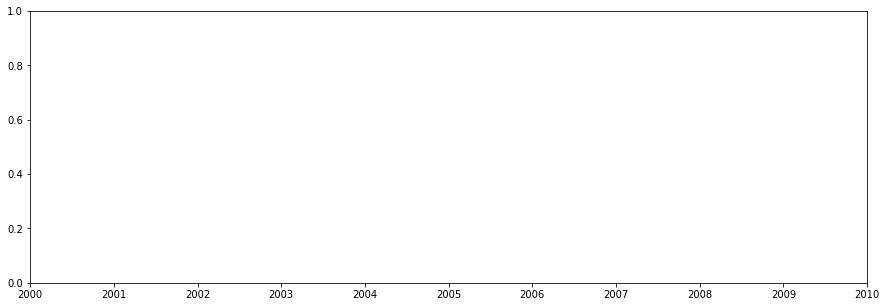

In [157]:
plt.plot(dates, pfizer_close[:-n], label="Closing Price, C")
plt.plot(dates, moving_avg, label=f"Moving Average ({n}-day), A")
plt.plot(dates, sq_dist_from_avg, label="(C - A)^2")
plt.legend()
plt.xlabel("Day")
plt.ylabel("Price")
plt.rcParams["figure.figsize"]=(15, 5)
plt.show()